In [527]:
# ライブラリーのインポート
import warnings
warnings.filterwarnings('ignore')

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


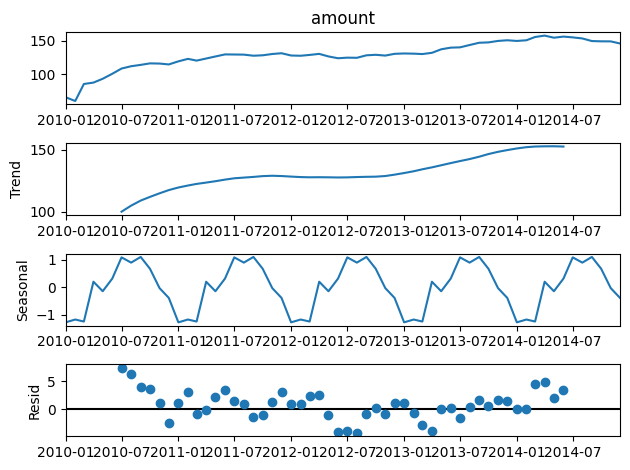

In [528]:
df5 = pd.read_excel('gaibu3.xlsx',sheet_name='hk12MA')


# float型に変換
df5['amount'] = df5['amount'].astype('float64')
# datetime型にしてインデックスにする
df5.Date = pd.to_datetime(df5.Date)
df5 = df5.set_index("Date")
df = df5
#df.head()
res = sm.tsa.seasonal_decompose(df["amount"])
fig = res.plot()

In [529]:
# 学習と評価データに分割
df_train = df[df.index < '2014-01-01']
df_test = df[df.index >= '2014-01-01']


ts = df.amount
ts_gaibu = ts.copy()
ts_train = df_train.amount
ts_test = df_test.amount

ts_train_gaibu = ts_train 
ts_test_gaibu = ts_test

print(f' df_train: { len(df_train) }   df_test : { len(df_test) } ')
ts_test

 df_train: 48   df_test : 12 


Date
2014-01-01    149.986973
2014-02-01    151.002777
2014-03-01    155.916191
2014-04-01    158.016588
2014-05-01    154.854555
2014-06-01    156.527291
2014-07-01    155.350047
2014-08-01    153.747737
2014-09-01    149.816270
2014-10-01    149.425561
2014-11-01    149.328633
2014-12-01    146.163459
Name: amount, dtype: float64

In [530]:
import itertools
 
# 各パラメータの範囲を決める
p = d = q = range(0, 3)
sp = sd = sq = range(0, 3)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

In [531]:
import warnings
warnings.filterwarnings("ignore") # warnings を表示させないようにする


In [532]:
from statsmodels.tsa.arima.model import ARIMA

count = 0
mape_min = 100
best_result = [0,  10000000]  # MAPEの初期値として大きい値をいれておく
for param in pdq:
    #for param_seasonal in seasonal_pdq:
    mod = ARIMA(ts_train,   order = param)                  # p d q をセット
    results = mod.fit()

    test_pred = results.forecast(len(ts_test))
    df_pred = pd.DataFrame(test_pred)  #予測値をdfへ
    df_pred_reset = df_pred.reset_index()  
    df_test_reset = df_test.reset_index()

    MAPE = 0
    for i in range(len(df_test_reset)):
        MAPE +=  np.abs(  df_test_reset.iloc[i,1] -   df_pred_reset.iloc[i,1]  )  / df_test_reset.iloc[i,1]  * 100
    MAPE /= len(df_test_reset)
        
    print('order{}  - MAPE: {}  BEST: {} {}'.format(param, MAPE,best_result[0],best_result[1]))
    count += 1

    if MAPE < best_result[1]:
        print(count)
        best_result = [param, MAPE]


order(0, 0, 0)  - MAPE: 19.247232143088635  BEST: 0 10000000
1
order(0, 0, 1)  - MAPE: 18.45115593895353  BEST: (0, 0, 0) 19.247232143088635
2
order(0, 0, 2)  - MAPE: 17.522184863954816  BEST: (0, 0, 1) 18.45115593895353
3
order(0, 1, 0)  - MAPE: 2.0957075921276327  BEST: (0, 0, 2) 17.522184863954816
4
order(0, 1, 1)  - MAPE: 2.0966579214357908  BEST: (0, 1, 0) 2.0957075921276327
order(0, 1, 2)  - MAPE: 2.0864206734129342  BEST: (0, 1, 0) 2.0957075921276327
6
order(0, 2, 0)  - MAPE: 3.8607728420388163  BEST: (0, 1, 2) 2.0864206734129342
order(0, 2, 1)  - MAPE: 6.09916368170398  BEST: (0, 1, 2) 2.0864206734129342
order(0, 2, 2)  - MAPE: 5.835689140369946  BEST: (0, 1, 2) 2.0864206734129342
order(1, 0, 0)  - MAPE: 2.460018970390556  BEST: (0, 1, 2) 2.0864206734129342
order(1, 0, 1)  - MAPE: 2.6143626525544432  BEST: (0, 1, 2) 2.0864206734129342
order(1, 0, 2)  - MAPE: 2.452053164255153  BEST: (0, 1, 2) 2.0864206734129342
order(1, 1, 0)  - MAPE: 2.096591535659648  BEST: (0, 1, 2) 2.086420

In [533]:
def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci
    

In [534]:
# BEST: (0, 1, 2) 2.0864206734129342
order=(2,1,2)
#seasonal_order=(1,0,2,12) 

model = ARIMA(
    ts_train,
    order=order)
    # seasonal_order=seasonal_order,
    # enforce_stationarity=True,
    # enforce_invertibility=True)
result = model.fit()
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()


RMSE(train):	10.501
RMSE(test):	4.473


In [535]:

train_pred = result.predict()
test_pred = result.forecast(len(ts_test))
test_pred_ci = result.get_forecast(len(ts_test)).conf_int()


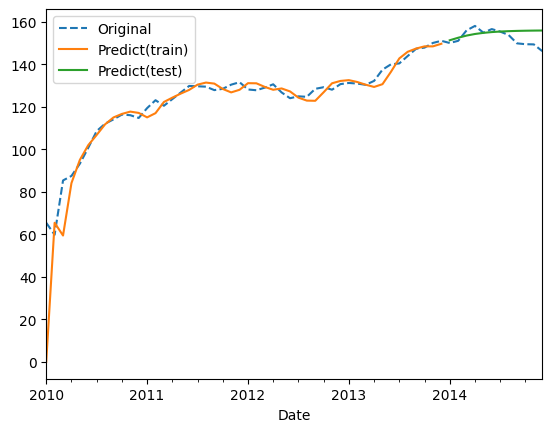

In [536]:
fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
train_pred.plot(ax=ax, label='Predict(train)')
test_pred.plot(ax=ax, label='Predict(test)')
# ax.fill_between(
#     test_pred_ci.index,
#     test_pred_ci.iloc[:, 0],
#     test_pred_ci.iloc[:, 1],
#     color='k',
#     alpha=.2)
ax.legend()

In [537]:
model = ARIMA(
    ts,             # ts: データ全体でfit
    order=order)
    # seasonal_order=seasonal_order,
    # enforce_stationarity=True,
    # enforce_invertibility=True)
result = model.fit()
#train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()

sarima_pred = result.predict('2015-01-01', '2016-03-01')   #予測 


In [538]:
df_sarima_pred = pd.DataFrame(sarima_pred)
df_sarima_pred_reset = df_sarima_pred.reset_index()
df_sarima_pred_reset['Item'] ='PAC_TOTAL'
df_sarima_pred_reset = df_sarima_pred_reset.rename(columns={'index': 'Date'  , 'predicted_mean':'amount_forecast'})
print(df_sarima_pred_reset)
df_sarima_pred_reset.to_csv('a.csv' , index=False)


         Date  amount_forecast       Item
0  2015-01-01       145.154049  PAC_TOTAL
1  2015-02-01       143.900956  PAC_TOTAL
2  2015-03-01       142.767020  PAC_TOTAL
3  2015-04-01       141.726448  PAC_TOTAL
4  2015-05-01       140.772233  PAC_TOTAL
5  2015-06-01       139.897177  PAC_TOTAL
6  2015-07-01       139.094714  PAC_TOTAL
7  2015-08-01       138.358823  PAC_TOTAL
8  2015-09-01       137.683980  PAC_TOTAL
9  2015-10-01       137.065121  PAC_TOTAL
10 2015-11-01       136.497601  PAC_TOTAL
11 2015-12-01       135.977162  PAC_TOTAL
12 2016-01-01       135.499898  PAC_TOTAL
13 2016-02-01       135.062227  PAC_TOTAL
14 2016-03-01       134.660865  PAC_TOTAL


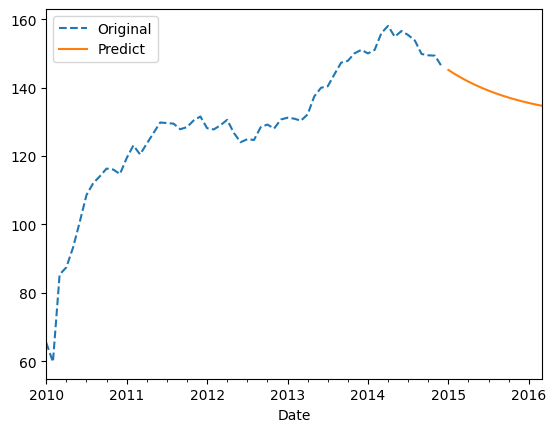

In [539]:
fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
sarima_pred.plot(ax=ax, label='Predict')
ax.legend()

In [540]:
import plotly
init_notebook_mode(connected=True)
save_image = None # 'png' if save image

df = pd.read_csv('./train/PAC_Total_1412.csv')


In [541]:
df=df[['Date','amount']]
df.head()

Date       amount
0  2010/1/1  105639.2912
1  2010/2/1  111807.9553
2  2010/3/1  146829.8900
3  2010/4/1  103340.4407
4  2010/5/1  123905.1050

In [542]:
# float型に変換
df['amount'] = df['amount'].astype('float64')
# datetime型にしてインデックスにする
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")


In [543]:
df.head()

amount
Date                   
2010-01-01  105639.2912
2010-02-01  111807.9553
2010-03-01  146829.8900
2010-04-01  103340.4407
2010-05-01  123905.1050

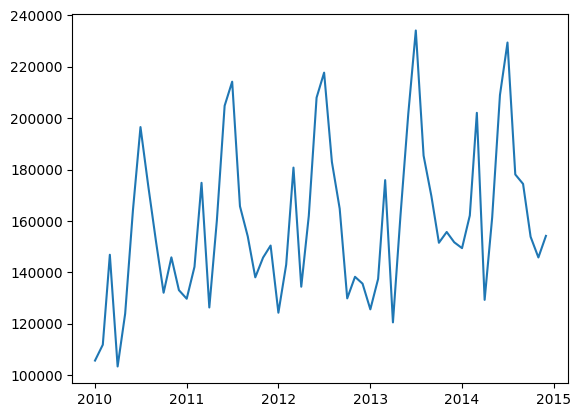

In [544]:
# データの可視化
plt.plot(df.amount)
plt.show()

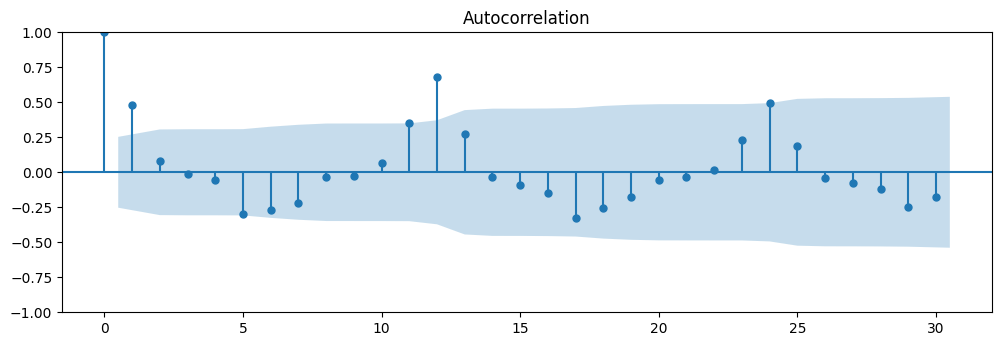

In [545]:
# コレログラム
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.amount, lags=30, ax=ax1)


In [546]:
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.amount, lags=20, ax=ax2)   #出ない

In [547]:
res = sm.tsa.stattools.adfuller(df.amount)
print('p-value = {:.4}'.format(res[1]))
#p-value = 0.9919
#Passengers: p-value > 0.1なので有意水準10%で帰無仮説（定常性を満たす）は棄却されず、定常ではない

p-value = 0.07452


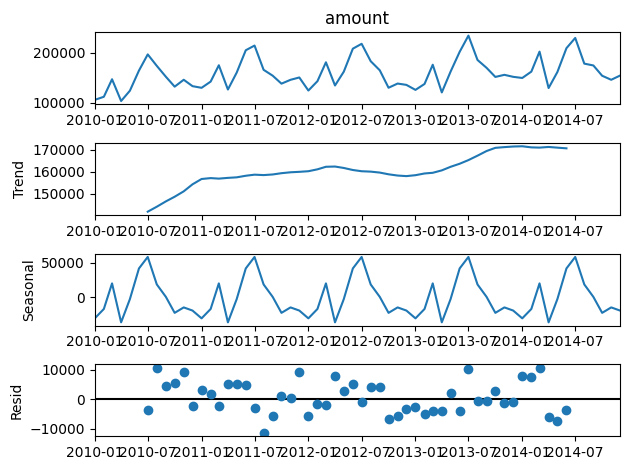

In [548]:
res = sm.tsa.seasonal_decompose(df["amount"])
fig = res.plot()
#本当は差分系列や対数差分系列など、細かい確認が必要

In [549]:
# 学習と評価データに分割
df_train = df[df.index < '2014-01-01']
df_test = df[df.index >= '2014-01-01']

ts = df.amount
ts_train = df_train.amount
ts_test = df_test.amount


print(f' df_train: { len(df_train) }   df_test : { len(df_test) } ')
ts_test

 df_train: 48   df_test : 12 


Date
2014-01-01    149398.3286
2014-02-01    162105.7275
2014-03-01    202075.8278
2014-04-01    129269.9066
2014-05-01    161296.9635
2014-06-01    208999.3383
2014-07-01    229434.1102
2014-08-01    178082.4939
2014-09-01    174403.8429
2014-10-01    153834.2769
2014-11-01    145776.0459
2014-12-01    154167.5857
Name: amount, dtype: float64

In [550]:
import itertools
 
# 各パラメータの範囲を決める
p = d = q = range(0, 3)
sp = sd = sq = range(0, 3)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

In [551]:
print(len(ts_train) , len(ts_train_gaibu))

48 48


In [552]:
import warnings
warnings.filterwarnings("ignore") # warnings を表示させないようにする


count = 0
mape_min = 100
best_result = [0, 0, 10000000]  # MAPEの初期値として大きい値をいれておく
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(  endog=ts_train,
                        exog=ts_train_gaibu,
                        order = param,                 # p d q をセット
                        seasonal_order=param_seasonal, # P D Q をセット
                        enforce_stationarity=True,    # enforce_stationarity 推定されるAR部分が定常性を持つように強制する
                        enforce_invertibility=True)   # enforce_invertibility 推定されるMA部分が反転可能性を持つように強制する

        results = mod.fit()

        test_pred = results.forecast(len(ts_test), exog=ts_test_gaibu )
        df_pred = pd.DataFrame(test_pred)  #予測値をdfへ
        df_pred_reset = df_pred.reset_index()  
        df_test_reset = df_test.reset_index()

        MAPE = 0
        for i in range(len(df_test_reset)):
            MAPE +=  np.abs(  df_test_reset.iloc[i,1] -   df_pred_reset.iloc[i,1]  )  / df_test_reset.iloc[i,1]  * 100
        MAPE /= len(df_test_reset)

        print('order{}, s_order{} - AIC: {} - MAPE: {}  BEST: {}{}{}'.format(param, param_seasonal,results.aic, MAPE,best_result[0],best_result[1],best_result[2]))
        count += 1

        if MAPE < best_result[2]:
            print(count)
            best_result = [param, param_seasonal, MAPE]






order(0, 0, 0), s_order(0, 0, 0, 12) - AIC: 1267.896977047674 - MAPE: 18.788341762644162  BEST: 0010000000
1
order(0, 0, 0), s_order(0, 0, 1, 12) - AIC: 1111.3389786288863 - MAPE: 10.397026760878889  BEST: (0, 0, 0)(0, 0, 0, 12)18.788341762644162
2
order(0, 0, 0), s_order(0, 0, 2, 12) - AIC: 1111.8430998072627 - MAPE: 10.848585361816726  BEST: (0, 0, 0)(0, 0, 1, 12)10.397026760878889
order(0, 0, 0), s_order(0, 1, 0, 12) - AIC: 767.9824271409481 - MAPE: 5.083776933634042  BEST: (0, 0, 0)(0, 0, 1, 12)10.397026760878889
4
order(0, 0, 0), s_order(0, 1, 1, 12) - AIC: 769.9193513426461 - MAPE: 5.073033949751689  BEST: (0, 0, 0)(0, 1, 0, 12)5.083776933634042
5
order(0, 0, 0), s_order(0, 1, 2, 12) - AIC: 771.4982753971068 - MAPE: 5.130945439039821  BEST: (0, 0, 0)(0, 1, 1, 12)5.073033949751689
order(0, 0, 0), s_order(0, 2, 0, 12) - AIC: 588.9227566873924 - MAPE: 6.595180462261922  BEST: (0, 0, 0)(0, 1, 1, 12)5.073033949751689
order(0, 0, 0), s_order(0, 2, 1, 12) - AIC: 537.0481720057985 - MAPE

In [553]:
def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci
    
    

In [554]:
# order=(2,0,3)
# seasonal_order=(0,1,1,12)  # MAPE  False   range(0, 4) 最も良いモデル: [(2, 0, 3), (0, 1, 1, 12), 3.881651820281011]  意外とよくない

# MAPE  False   range(0, 3) 最も良いモデル: [(1, 0, 2), (0, 1, 1, 12), 4.069448946913686]
# order=(1,0,2)
# seasonal_order=(0,1,1,12) 

#  MAPE  True   range(0, 4)   最も良いモデル: [(1, 2, 2), (0, 1, 2, 12), 3.904849327482459]
# BEST: (2, 2, 2)(2, 1, 0, 12)3.896612042897979  sarimax true 
order=(2,2,2)
seasonal_order=(2,1,0,12)  


# order=(2,1,1)
# seasonal_order=(2,2,0,12)  # aic 12.0

model = SARIMAX(
    endog=ts_train,
    exog=ts_gaibu,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True)
result = model.fit()
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()


ValueError: The indices for endog and exog are not aligned

In [ ]:

train_pred = result.predict()
test_pred = result.forecast(len(ts_test))
test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

train_rmse = np.sqrt(mean_squared_error(df_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test, test_pred))
print('RMSE(train): {:.5}\nRMSE(test): {:.5}'.format(train_rmse, test_rmse))


In [ ]:

fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
train_pred.plot(ax=ax, label='Predict(train)')
test_pred.plot(ax=ax, label='Predict(test)')
# ax.fill_between(
#     test_pred_ci.index,
#     test_pred_ci.iloc[:, 0],
#     test_pred_ci.iloc[:, 1],
#     color='k',
#     alpha=.2)
ax.legend()

In [ ]:
# sarima_pred = result.predict('2015-01-01', '2016-03-01') 


In [ ]:

# plt.figure(figsize=(8, 4))
# plt.plot(df.amount, label="original")
# plt.plot(sarima_pred, c="b", label="model-pred", alpha=0.7)
# plt.legend(loc='best')


In [ ]:
ts_gaibu

In [ ]:
model = SARIMAX(
    endog=ts,             # ts: データ全体でfit
    exog=ts_gaibu,
    enforce_invertibility=True,
    enforce_stationarity=True,
    order=order,
    seasonal_order=seasonal_order    
    )
result = model.fit()
#train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()


sarima_pred = result.forecast(steps=15,exog= df_sarima_pred_reset['amount_forecast']) 
#sarima_pred = result.predict('2015-01-01', '2016-03-01')   #予測 


In [ ]:
df_sarima_pred = pd.DataFrame(sarima_pred)
df_sarima_pred_reset = df_sarima_pred.reset_index()
df_sarima_pred_reset['Item'] ='PAC_TOTAL'
df_sarima_pred_reset = df_sarima_pred_reset.rename(columns={'index': 'Date'  , 'predicted_mean':'amount_forecast'})
print(df_sarima_pred_reset)
df_sarima_pred_reset.to_csv('a.csv' , index=False)


In [ ]:
fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
sarima_pred.plot(ax=ax, label='Predict')
ax.legend()

In [ ]:
df_sarima_pred = df_sarima_pred.rename(columns={'index': 'Date'  , 'predicted_mean':'amount'})
df = df.append(df_sarima_pred)
res = sm.tsa.seasonal_decompose(df)
fig = res.plot()